## Predict sea ice concentration with sea surface flux using transformer with multi-head attention
This notebook serves as an example of a basic workflow with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with multi-head attention transformer. <br>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data
- Map the calendar to the data (`lilio`)
- Train-validate-test split (70%/15%/15%) (`torch`)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Create transformer model (`torch`)
- Specify hyper-parameters
- Train model (`torch`)
- Evaludate model

In [1]:
import lilio
import numpy as np
import time as tt
import wandb
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as f

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [2]:
# create NWP calendar for constrained forecasts/hindcasts
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01")
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 6
for _ in range(periods_of_interest):
    calendar.add_intervals("precursor", "15d", gap="15d")

In [3]:
# check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=False,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='0d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d')
    ]
)

In [4]:
# load data
data_folder = '~/AI4S2S/data'
precursor_field = xr.open_dataset(Path(data_folder, 'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))
target_field = xr.open_dataset(Path(data_folder,'tf5_nc5_dendo_80d77.nc'))

#### Map the calendar to the data

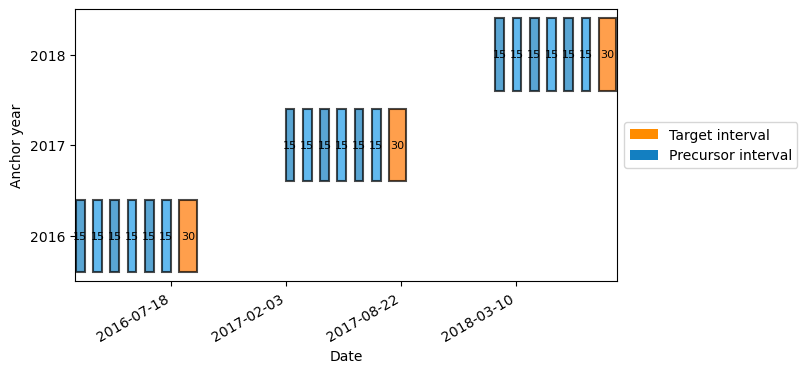

In [5]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

In [6]:
calendar.show()[:5]

i_interval,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,
2018,"[2018-02-02, 2018-02-17)","[2018-03-04, 2018-03-19)","[2018-04-03, 2018-04-18)","[2018-05-03, 2018-05-18)","[2018-06-02, 2018-06-17)","[2018-07-02, 2018-07-17)","[2018-08-01, 2018-08-31)"
2017,"[2017-02-02, 2017-02-17)","[2017-03-04, 2017-03-19)","[2017-04-03, 2017-04-18)","[2017-05-03, 2017-05-18)","[2017-06-02, 2017-06-17)","[2017-07-02, 2017-07-17)","[2017-08-01, 2017-08-31)"
2016,"[2016-02-03, 2016-02-18)","[2016-03-04, 2016-03-19)","[2016-04-03, 2016-04-18)","[2016-05-03, 2016-05-18)","[2016-06-02, 2016-06-17)","[2016-07-02, 2016-07-17)","[2016-08-01, 2016-08-31)"
2015,"[2015-02-02, 2015-02-17)","[2015-03-04, 2015-03-19)","[2015-04-03, 2015-04-18)","[2015-05-03, 2015-05-18)","[2015-06-02, 2015-06-17)","[2015-07-02, 2015-07-17)","[2015-08-01, 2015-08-31)"
2014,"[2014-02-02, 2014-02-17)","[2014-03-04, 2014-03-19)","[2014-04-03, 2014-04-18)","[2014-05-03, 2014-05-18)","[2014-06-02, 2014-06-17)","[2014-07-02, 2014-07-17)","[2014-08-01, 2014-08-31)"


#### Train-validate-test split based on the anchor years (70%/15%/15% split)

In [7]:
# get 70% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.7)
test_samples = round(len(years) * 0.15)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
Remove trend and take anomalies for the precursor field.

In [8]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(precursor_field.sel(time=slice(str(start_year),
                                                str(start_year + train_samples - 1))))

In [9]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

Resample data to the calendar

In [10]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [11]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['ts'].sel(cluster=3)

In [12]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude) - 1 # selection made for transformer desired dimension
lon_precursor = len(precursor_field_sel.longitude) - 1 # same as above

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:-1,:-1].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)
y_torch = y_torch.unsqueeze(1).unsqueeze(1).repeat(1, 1, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

In [13]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

# data loader
# train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

#### Create tansformer with multihead attention using pytorch

In [14]:
def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    temp = query.bmm(key.transpose(1, 2))
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale, dim=-1)
    return softmax.bmm(value)
     

class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_k)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))
     

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_q, dim_k) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_k, dim_in)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return self.linear(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )

In [15]:
# positional embedding
def position_encoding(
    seq_len: int, dim_model: int, device: torch.device = torch.device("cpu"),
) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim / dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

In [16]:
def feed_forward(dim_input: int = 512, dim_feedforward: int = 2048,
                 activation: nn.Module = nn.ReLU()) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        activation,
        nn.Linear(dim_feedforward, dim_input),
    )

In [17]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "query" tensor is given first, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[0] + self.dropout(self.sublayer(*tensors)))

In [18]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward, activation),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout, activation)
                for _ in range(num_layers)
            ]
        )

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(1), src.size(2)
        src += position_encoding(seq_len, dimension)
        for layer in self.layers:
            src = layer(src)

        return src

In [19]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward, activation),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        tgt = self.attention_1(tgt, tgt, tgt)
        tgt = self.attention_2(tgt, memory, memory)
        return self.feed_forward(tgt)
    
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout, activation)
                for _ in range(num_layers)
            ]
        )
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        seq_len, dimension = tgt.size(1), tgt.size(2)
        tgt += position_encoding(seq_len, dimension)
        for layer in self.layers:
            tgt = layer(tgt, memory)

        return torch.softmax(self.linear(tgt), dim=-1)

In [20]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        return self.decoder(tgt, self.encoder(src))

#### Hyper-parameter tuning with W&B
System info and syncronize training information with W&B server.

In [21]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))
# call weights & biases service
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Pytorch version 1.12.1
Is CUDA available? False
Device to be used for computation: cpu


wandb: Currently logged in as: git-yang (ai4s2s). Use `wandb login --relogin` to force relogin


True

Define hyperparameters and initialize config for wandb.

In [22]:
hyperparameters = dict(
    epoch = 10,
    num_encoder_layers = 1,
    num_decoder_layers = 1,
    dim_model = 48,
    num_heads = 2,
    dim_feedforward = 12,
    batch_size = 4,
    dropout = 0.1,
    learning_rate = 0.001,
    dataset = 'Weather',
    architecture = 'Transformer'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='geometric-shapes', entity='dianna-ai', mode=mode)
config = wandb.config

In [23]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

#### Train model
Initialize model and choose loss function and optimizer.

In [24]:
# Initialize model
model = Transformer(num_encoder_layers = hyperparameters["num_encoder_layers"],
                    num_decoder_layers = hyperparameters["num_decoder_layers"],
                    dim_model = hyperparameters["dim_model"], 
                    num_heads = hyperparameters["num_heads"], 
                    dim_feedforward = hyperparameters["dim_feedforward"], 
                    dropout = hyperparameters["dropout"])
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)

Model details:
 Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): Residual(
          (sublayer): MultiHeadAttention(
            (heads): ModuleList(
              (0): AttentionHead(
                (q): Linear(in_features=48, out_features=24, bias=True)
                (k): Linear(in_features=48, out_features=24, bias=True)
                (v): Linear(in_features=48, out_features=24, bias=True)
              )
              (1): AttentionHead(
                (q): Linear(in_features=48, out_features=24, bias=True)
                (k): Linear(in_features=48, out_features=24, bias=True)
                (v): Linear(in_features=48, out_features=24, bias=True)
              )
            )
            (linear): Linear(in_features=48, out_features=48, bias=True)
          )
          (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
       

Start the training loop.

In [26]:
# switch model into train mode
model.train()

# calculate the time for the code execution
start_time = tt.time()

for epoch in range(config.epoch):
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        output = model(var_X_batch, var_y_batch)
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        if batch_idx % 20 == 0:
            print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
                  f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    # add validation results
    # for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):

Epoch : 0 [0/28(0%)]	Loss: 2.225106
Epoch : 1 [0/28(0%)]	Loss: 2.216071
Epoch : 2 [0/28(0%)]	Loss: 2.211614
Epoch : 3 [0/28(0%)]	Loss: 2.208896
Epoch : 4 [0/28(0%)]	Loss: 2.207437
Epoch : 5 [0/28(0%)]	Loss: 2.206661
Epoch : 6 [0/28(0%)]	Loss: 2.206189
Epoch : 7 [0/28(0%)]	Loss: 2.205882
Epoch : 8 [0/28(0%)]	Loss: 2.205631
Epoch : 9 [0/28(0%)]	Loss: 2.205462


#### Evaluate model

Visualization